# FATS


In [1]:
import pandas as pd
import numpy as np
import functools
import re
import matplotlib.pyplot as plt
import seaborn as sns

Read all data

In [2]:
data_folder = "./data/"

In [3]:
france = pd.read_csv(data_folder + "france_data.csv.zip", sep=',', dtype=object)

In [4]:
us = pd.read_csv(data_folder + "us_data.csv.zip", sep=',', dtype=object)

In [5]:
def relevant_rows(df, tag_list):
    import functools
    import re
    cols = ['categories_en', 'categories', 'product_name']
    combinations = [df[col].str.contains(tag, na=False, flags=re.IGNORECASE) for tag in tag_list for col in cols]
    mask = functools.reduce(lambda x,y: x | y, combinations)
    return df[mask]

In [6]:
def clean_categories(df, wrong_strings, wrong_ingredients = []):
    cols = ['categories_en', 'categories', 'product_name']
    combinations = [df[col].str.contains(wrong, na=False, flags=re.IGNORECASE) for wrong in wrong_strings for col in cols]
    ingredient_combinations = [df['ingredients_text'].str.contains(wrong, na=False, flags=re.IGNORECASE) for wrong in wrong_ingredients]
    mask = functools.reduce(lambda x,y: x | y, combinations + ingredient_combinations)
    return df[~mask]

Select the "dairy" data

In [140]:
dairy_words = ["dairy","milk","cream","cheese","yaourt","fromage","de lait","yog"]
non_dairy_words = ["dairy free","non dairy","dairy-free","milk chocolat","cheeseburger","bacon","sandwich", "pasta","macaroni",
                  "non-dairy"," pain ", "beurre", " cake "]

In [128]:
france_dairy = relevant_rows(france, dairy_words)
print("Diary related items in France before cleaning: " + str(france_dairy.shape[0]))
us_dairy = relevant_rows(us, dairy_words)
print("Diary related items in US before cleaning: " + str(us_dairy.shape[0]))


Diary related items in France before cleaning: 31835
Diary related items in France after cleaning: 28559


In [141]:
france_dairy = clean_categories(france_dairy, non_dairy_words)
print("Diary related items in France after cleaning: " + str(france_dairy.shape[0]))
us_dairy = clean_categories(us_dairy, non_dairy_words)
print("Diary related items in US after cleaning: " + str(us_dairy.shape[0]))

Diary related items in France after cleaning: 27617


Diary related items in US after cleaning: 22535


In [31]:
def create_distribution(df,categories):
    distribution = pd.DataFrame(columns=['tag','category','count'])
    for i in range(categories.shape[0]):
        tag = categories[i,0]
        category = categories[i,1]
        newRow = pd.DataFrame([[tag, category, relevant_rows(df,[tag]).shape[0]]], columns=['tag','category','count'])
        distribution = distribution.append(newRow)
        df = clean_categories(df, [tag])
    return distribution, df.shape[0], df

In [107]:
tags = np.matrix([['yaourt', "yogurt"], 
                  ["yogurt", "yogurt"],
                  ["yog", "yogurt"],
                  ["cheddar", "cheddar"],
                  ["cheese", "cheese"],
                  ["fromage", "cheese"],
                  ["ice", "ice cream"],
                  ["cream", "cream"],
                  ["dessert", "dessert"],
                  ["milk", "milk"],
                ])

In [143]:
france_distri, leftovers , rest = create_distribution(france_dairy,tags)
france_distri_grouped = france_distri.groupby(['category']).sum().drop('tag', axis = 1)
france_distri_grouped['procent'] = france_distri_grouped['count'].apply(lambda x: x/france_distri_grouped['count'].sum())
france_distri_grouped['country'] = "France"

In [144]:
us_distri, leftovers , rest = create_distribution(us_dairy,tags)
us_distri_grouped = us_distri.groupby(['category']).sum().drop('tag', axis = 1)
us_distri_grouped['procent'] = us_distri_grouped['count'].apply(lambda x: x/us_distri_grouped['count'].sum())
us_distri_grouped['country'] = "US"

In [145]:
distribution = france_distri_grouped.append(us_distri_grouped).reset_index()
distribution

,category,count,procent,country
0,cheddar,153,0.005600,France
1,cheese,11286,0.413074,France
2,cream,2308,0.084474,France
3,dessert,973,0.035612,France
4,ice cream,2011,0.073604,France
5,milk,4056,0.148452,France
6,yogurt,6535,0.239185,France
7,cheddar,1734,0.077428,US
8,cheese,7856,0.350793,US
9,cream,3247,0.144988,US


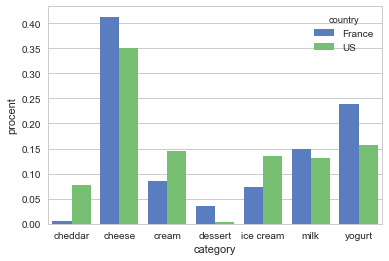

In [146]:
sns.set(style="whitegrid")

g = sns.barplot(x='category', y="procent", hue="country", data=distribution,palette="muted")

